In [1]:
import time
import pandas as pd
import gc

# helper function to test the different implementations of matrix multiplication
def test_function(function, identifier, A, B):
    gc.disable()
    start_time = time.time()
    C = function(A, B)
    end_time = time.time()
    duration = end_time - start_time
    gc.enable()
    print(f"duration for {identifier}: {duration:.4e}")

    return {"function": identifier, "duration": duration, "results": C}


In [2]:
import numpy as np 

A = np.array([[1, 2, 3], [4, 5, 6]]).astype(np.float64)
B = np.array([[7, 8], [9, 10], [11, 12]]).astype(np.float64)
A,B

(array([[1., 2., 3.],
        [4., 5., 6.]]),
 array([[ 7.,  8.],
        [ 9., 10.],
        [11., 12.]]))

## NUMPY Matrix Multiplication (Naive)

In [3]:
# define naive matrix multiplication in numpy
import numpy as np

def matrix_multiply_np(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i][j] += A[i][k] * B[k][j]
    return result


In [4]:

%%time
numpy_result = matrix_multiply_np(A, B)
numpy_result

CPU times: user 30 µs, sys: 14 µs, total: 44 µs
Wall time: 47.4 µs


array([[ 58.,  64.],
       [139., 154.]])

## NUMPY Matrix Multiplication (vectorized)

In [5]:

%%time
numpy_result_vec = np.matmul(A, B)
numpy_result_vec

CPU times: user 129 µs, sys: 62 µs, total: 191 µs
Wall time: 195 µs


array([[ 58.,  64.],
       [139., 154.]])

## NUMBA Matrix Multiplication

In [6]:
import numba 

@numba.jit(nopython=True)
def matrix_multiply_numba(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i][j] += A[i][k] * B[k][j]
    return result



## First time NUMBA Function is called

In [7]:
%%time
numba_result = matrix_multiply_numba(A, B)
numba_result

CPU times: user 1.53 s, sys: 946 ms, total: 2.47 s
Wall time: 728 ms


array([[ 58.,  64.],
       [139., 154.]])

## Second time NUMBA Function is called

In [8]:
%%time
numba_result = matrix_multiply_numba(A, B)
numba_result

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 33.9 µs


array([[ 58.,  64.],
       [139., 154.]])

## CYTHON Matrix Multiplication Version 1

In [9]:
%load_ext Cython

In [10]:
%%cython
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.locals(A=cython.double[:, :], B=cython.double[:, :], result=cython.double[:,:], i=cython.int, j=cython.int, k=cython.int)
def matrix_multiply_cython(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i][j] += A[i][k] * B[k][j]
    return np.asarray(result)



In [11]:
%time 
cython_result = matrix_multiply_cython(A, B)
cython_result

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


array([[ 58.,  64.],
       [139., 154.]])

## CYTHON Matrix Multiplication Version 2

In [12]:
%%cython

import numpy as np

cimport cython
from libc.stdlib cimport calloc, free

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef matrix_multiply_cython2(double[:, ::1] A, double [:, ::1] B):
    # Declare integer variables for loop counters and matrix dimensions
    cdef int i, j, k
    cdef int nrows_A = len(A)  # Number of rows in matrix A
    cdef int ncols_B = len(B[0])  # Number of columns in matrix B
    cdef int ncols_A = len(A[0])  # Number of columns in matrix A

    # Allocate memory for the result matrix and initialize it with zeros
    cdef double[:,:] result = <double[:nrows_A, :ncols_B]> calloc(nrows_A * ncols_B, sizeof(double))

    # Perform matrix multiplication
    for i in range(nrows_A):  # Iterate over rows of A
        for j in range(ncols_B):  # Iterate over columns of B
            # Compute dot product of i-th row of A and j-th column of B
            for k in range(ncols_A):
                result[i][j] += A[i][k] * B[k][j]

    # Return the result matrix
    return np.asarray(result)

In [13]:
%time 
cython_result2 = matrix_multiply_cython2(A, B)
cython_result2

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


array([[ 58.,  64.],
       [139., 154.]])

## TAICHI Matrix Multiplication

In [14]:
import taichi as ti

ti.init(arch=ti.cpu)  # Use CPU by default

def matrix_multiply_taichi(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    C = ti.field(shape=(A.shape[0], B.shape[1]), dtype=ti.f64)

    # Convert the numpy arrays to Taichi ndarrays
    A_ti = ti.field(shape=A.shape, dtype=ti.f64)
    B_ti = ti.field(shape=B.shape, dtype=ti.f64)
    A_ti.from_numpy(A)
    B_ti.from_numpy(B)
    sum = ti.field(dtype=ti.f64, shape=())

    @ti.kernel
    def _taichi_compute():
        ti.loop_config(serialize=True)
        for i in range(A.shape[0]):
            for j in range(B.shape[1]):
                sum[None] = 0.0
                for k in range(A.shape[1]):
                    sum[None] += A_ti[i, k] * B_ti[k, j]
                C[i,j] = sum[None]

    _taichi_compute()
    return C.to_numpy()


[Taichi] version 1.7.0, llvm 15.0.4, commit 2fd24490, linux, python 3.10.12


[I 12/30/23 03:37:11.152 7523] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=x64


In [15]:
%time 
taichi_result = matrix_multiply_taichi(A, B)
taichi_result

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


array([[ 58.,  64.],
       [139., 154.]])

In [16]:
%time 
taichi_result = matrix_multiply_taichi(A, B)
taichi_result

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


array([[ 58.,  64.],
       [139., 154.]])

## Large Matrix Multiplication

In [17]:
# list to collect run-time metrics
# initialize with results for native C implementation
test_results = [
    {"function": "native_c", "duration": 0.0105, "results": None}
]

DIM_SIZE = 200
np.random.seed(0)
# Create two random square matrices
A = np.random.rand(DIM_SIZE, DIM_SIZE)
B = np.random.rand(DIM_SIZE, DIM_SIZE)
A.shape, B.shape


((200, 200), (200, 200))

## NUMPY Naive LARGE MATRIX Multiplication

In [18]:
%%time
test_results.append(test_function(matrix_multiply_np, "numpy_naive", A, B))

duration for numpy_naive: 5.4332e+00
CPU times: user 5.43 s, sys: 0 ns, total: 5.43 s
Wall time: 5.43 s


## NUMPY Vectorized LARGE MATRIX Multiplication

In [19]:
%%time
test_results.append(test_function(np.matmul, "numpy_vectorized", A, B))

duration for numpy_vectorized: 6.5794e-03
CPU times: user 95.8 ms, sys: 0 ns, total: 95.8 ms
Wall time: 6.74 ms


## NUMBA LARGE MATRIX Multiplication

In [20]:
%%time
test_results.append(test_function(matrix_multiply_numba, "numba", A, B))

duration for numba: 1.0888e-02
CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 11.1 ms


## TAICHI LARGE MATRIX Multiplication

In [21]:
%%time
test_results.append(test_function(matrix_multiply_taichi, "taichi", A, B))

duration for taichi: 2.5988e-01
CPU times: user 476 ms, sys: 154 ms, total: 630 ms
Wall time: 260 ms


## CYTHON LARGE MATRIX Multiplication Version 1

In [22]:
%%time
test_results.append(test_function(matrix_multiply_cython, "cythonv1", A, B))

duration for cythonv1: 9.8970e-03
CPU times: user 9.74 ms, sys: 610 µs, total: 10.4 ms
Wall time: 10 ms


## CYTHON MATRIX Multiplication Version 2

In [23]:
%%time
test_results.append(test_function(matrix_multiply_cython2,"cythonv2", A, B))

duration for cythonv2: 9.5940e-03
CPU times: user 9.81 ms, sys: 984 µs, total: 10.8 ms
Wall time: 10.2 ms


In [24]:
df = pd.DataFrame(test_results)
df['speed_up'] = df[df.function == 'numpy_naive'].duration.values[0] / df['duration'] 
df

,function,duration,results,speed_up
0,native_c,0.010500,None,517.445587
1,numpy_naive,5.433179,"[[46.7619035508464, 51.01059403987534, 50.7739...",1.000000
2,numpy_vectorized,0.006579,"[[46.7619035508464, 51.01059403987535, 50.7739...",825.786455
3,numba,0.010888,"[[46.7619035508464, 51.01059403987534, 50.7739...",499.012482
4,taichi,0.259884,"[[46.76190355084639, 51.010594039875365, 50.77...",20.906159
5,cythonv1,0.009897,"[[46.7619035508464, 51.01059403987534, 50.7739...",548.972634
6,cythonv2,0.009594,"[[46.7619035508464, 51.01059403987534, 50.7739...",566.312202


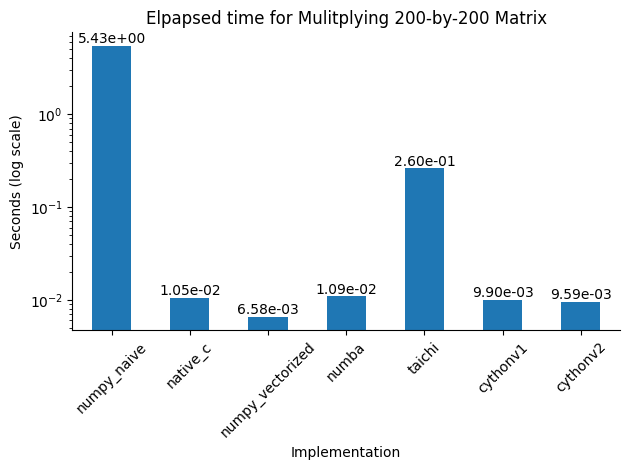

In [25]:
import matplotlib.pyplot as plt

# Define the desired order
order = ['numpy_naive', 'native_c', 'numpy_vectorized', 'numba', 'taichi', 'cythonv1', 'cythonv2']

# Sort the DataFrame by the 'function' column based on the desired order
df['function'] = df['function'].astype('category')
df['function'] = df['function'].cat.set_categories(order)
df.sort_values('function', inplace=True)

# Plot the data
ax = df.plot(kind='bar', x='function', y='duration', legend=False)

plt.xlabel('Implementation')
plt.ylabel('Seconds (log scale)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title(f'Elpapsed time for Mulitplying {DIM_SIZE}-by-{DIM_SIZE} Matrix')

# Add duration values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2e'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'top', 
                xytext = (0, 10), 
                textcoords = 'offset points')
# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

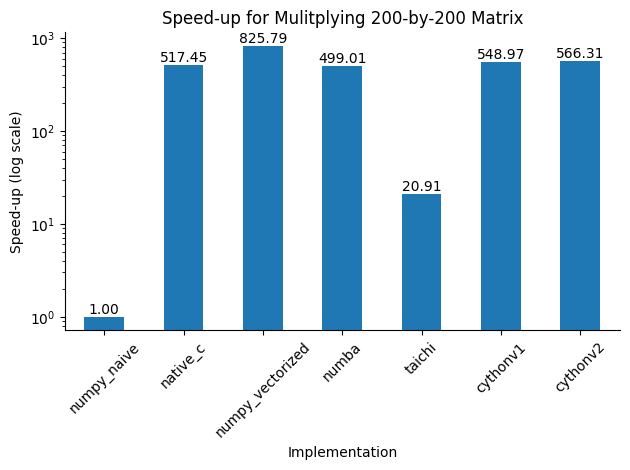

In [26]:
# Plot the data
ax = df.plot(kind='bar', x='function', y='speed_up', legend=False)

plt.xlabel('Implementation')
plt.ylabel('Speed-up (log scale)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title(f'Speed-up for Mulitplying {DIM_SIZE}-by-{DIM_SIZE} Matrix')

# Add duration values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'top', 
                xytext = (0, 10), 
                textcoords = 'offset points')
# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()